# Project 3: Web APIs & NLP

_Author:_ Omar Younis

---

## Contents:
- [Problem Statement](#Problem-Statement)
- [Data Collection](#Data-Collection)
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Processing & Modeling](#Processing-&-Modeling)
- [Evaluation and Conceptual Understanding](#Evaluation-and-Conceptual-Understanding)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)
---

## Problem Statement

DreamWorks is a animation studio which has a number of hit films. In the animation world, they are often compared to their Disney counterparts, Pixar. Because of this DreamWorks is looking to use targeting advertising to find Pixar fans and sway them to become DreamWorks fans. This project explores reddit comments in the `DreamWorks` and `Pixar` subreddits, to find language patterns to patterns to predict whether a person is a `Pixar` fan or a `DreamWorks` fan.

---

## Data Collection

#### Imports

In [267]:
"""This block contain all the imports needed for this document."""
# Imports
import re
import time
import requests
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

%matplotlib inline

#### Main Code

In [84]:
"""This block contains the functions and main code for collecting data for this document."""

###############
#  Settings   #
###############

pd.options.display.max_colwidth = 400
url = 'https://api.pushshift.io/reddit/search/comment'
subreddits = ['Pixar', 'DreamWorks']



###############
#  Functions  #
###############

def create_reddit_df(subreddit, length, year=2000, month=1, day=1):
    """Creates a pandas dataframe of posts from a selected subreddit. Dataframe minimum length specified."""
    # Converting date to epoch time and setting up params for requests.
    starting_date = int(datetime(year, month, day, 0, 0).timestamp())
    params = {
        'subreddit': subreddit,
        'size': 100,
        'before': starting_date,
    }

    # Getting data from the web (webscrapping)
    req = requests.get(url, params)
    page_status = req.status_code
    if page_status != 200:
        return f"Error Status Code: {page_status}"
    posts = req.json()['data']

    # Adding data to a new Pandas DataFrame. (Remove 'body' and replace with 'title' 'selftext' for posts).
    # Currently set up to grab comments instead of posts.
    df = pd.DataFrame(posts)[['subreddit','body', 'created_utc']]

    # Checking length of DataFrame and getting more entires if df.shape[0] < length (function param).
    run_flag = True
    while run_flag == True:
        # Getting last time entry from DataFrame and getting post from before that data.
        new_time = df['created_utc'].tail(1)
        params = {
            'subreddit': subreddit,
            'size': 100,
            'before': new_time,
        }

        req = requests.get(url, params)
        posts = req.json()['data']

        # Create a new DataFrame for the new posts and merges with the old DataFrame.
        df_temp = pd.DataFrame(posts)[['subreddit','body', 'created_utc']]
        df = pd.concat([df, df_temp])
        #print(df.shape)

        # Checks length of DataFrame to see if the loop should stop.
        if df.shape[0] >= length:
            run_flag = False
        else:
            time.sleep(1.0)
            
    return df


def create_master_df(subreddits, filename, length, year=2000, month=1, day=1):
    """Creates the a DataFrame of all the comments pulled from a list of subreddits and saves it to a csv file."""
    list_of_df = []
    
    # Looping through each subreddit.
    for subreddit in subreddits:
        df = create_reddit_df(subreddit, length=length, year=year, month=month, day=day)
        list_of_df.append(df)
     
    # Combining reddit DataFrames into on Master DataFrame and saving it to a .csv locally.
    master_df = pd.concat(list_of_df)
    master_df.to_csv(f'../data/{filename}.csv')

**Only run the block below once!**

In [35]:
create_master_df(subreddits, 'raw_comment_data', length=2500 , year=2021, month=9, day=12)

---

## Data Cleaning

In [143]:
# Import the data and check the headers and shape of the DataFrame.
df = pd.read_csv('../data/raw_comment_data.csv')
print(" Shape of DataFrame ".center(50, '-'))
print(df.shape)
print()
print(" Info DataFrame ".center(50, '-'))
print(df.info())
print()
print(" DataFrame Head ".center(50, '-'))
df.head()

--------------- Shape of DataFrame ---------------
(5000, 4)

----------------- Info DataFrame -----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   5000 non-null   int64 
 1   subreddit    5000 non-null   object
 2   body         5000 non-null   object
 3   created_utc  5000 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 156.4+ KB
None

----------------- DataFrame Head -----------------


,Unnamed: 0,subreddit,body,created_utc
0,0,Pixar,Lol another glimpse into a world I'll never know,1631428205
1,1,Pixar,Agreed!,1631420559
2,2,Pixar,"Cars was my first ever Pixar movie, I would watch it like everyday as a kid, I watched both Cars and Cars 2 like everyday when I was young, I still got the DVDs but they have so many scratches (so I got both New Blu-Rays and DVDs)",1631404031
3,3,Pixar,"Really liked Cqrs 2 anyway, but Pixar movies always have good scores/themes/music",1631403862
4,4,Pixar,[removed],1631403580


Because it is unlikely that reddit would allow a user to post a comment without anything in it, we can see that we have no missing values. However, as you can see, we have a little bit of cleaning to do. We need to remove any newline characters and whitespace characters from each post. After that, we want to get rid of any URLs that a comment might have in it. This way the URL won't count as a word when we come to `CountVercotrize` the comments. We are not getting ride of the comment itself, just the URL in the comment. The rest of the words in the comment will be preserved. Finally some post will have been removed or deleted, these posts have `[removed]` or `[deleted]` (these can be found by looking at the first 50 rows) in the body column. We will need to drop these columns since we have no information on them. Also we have to drop the `Unnamed: 0` column since we do not need it.

In [144]:
df.drop(columns = 'Unnamed: 0', inplace=True)
df.head()

,subreddit,body,created_utc
0,Pixar,Lol another glimpse into a world I'll never know,1631428205
1,Pixar,Agreed!,1631420559
2,Pixar,"Cars was my first ever Pixar movie, I would watch it like everyday as a kid, I watched both Cars and Cars 2 like everyday when I was young, I still got the DVDs but they have so many scratches (so I got both New Blu-Rays and DVDs)",1631404031
3,Pixar,"Really liked Cqrs 2 anyway, but Pixar movies always have good scores/themes/music",1631403862
4,Pixar,[removed],1631403580


In [183]:
# Renaming subreddit column.
df.rename(columns = {'subreddit': 'subreddit_name'}, inplace=True)

# First removing and extra whitespace on either side of the post. Then removing newlines.
df['body'] = df['body'].apply(lambda x: x.strip().replace('\n', ''))

# Removing URLs from comments
df['body'] = df['body'].apply(lambda x: re.sub(r'http\S+', '', x))

# Next we drop rows that have [removed] or [deleted] in the body column.
df = df[df['body'] != '[removed]']
df = df[df['body'] != '[deleted]']
df.head()

,subreddit_name,body,created_utc,comment_length,word_count
0,Pixar,Lol another glimpse into a world I'll never know,1631428205,48,9
1,Pixar,Agreed!,1631420559,7,1
2,Pixar,"Cars was my first ever Pixar movie, I would watch it like everyday as a kid, I watched both Cars and Cars 2 like everyday when I was young, I still got the DVDs but they have so many scratches (so I got both New Blu-Rays and DVDs)",1631404031,230,48
3,Pixar,"Really liked Cqrs 2 anyway, but Pixar movies always have good scores/themes/music",1631403862,81,12
5,Pixar,"I knew he and his team always has a contest on making the best puns for each cue, but I never knew about this one. Makes me love his work even more!Where did you get these?",1631403433,172,36


In [184]:
# Checking for Null Values after clean-up.
df.isnull().sum()

subreddit_name    0
body              0
created_utc       0
comment_length    0
word_count        0
dtype: int64

**Removing URLs from strings [source](https://www.codegrepper.com/code-examples/python/remove+urls+from+text+python).**

### Data Dictionary:
|Feature|Type|Description|
|---|---|---|
|**subreddit_name**|*object*|The name of the subreddit that the comment came from.|
|**body**|*object*|The contents of the comment.|
|**created_utc**|*int*|The epoch time stamp of when the comment was created.|
|**comment_length**|*int*|How many characters the comment contains.|
|**word_count**|*int*|How many words the comment contains.|

---

## Exploratory Data Analysis

Before we `CountVectorize()` the contents of all our reddit comments, let's first look at some basic EDA on our post lengths. To do this, let's add two extra columns to our current `DataFrame`, `word_count` and `comment_length`. With these two columns we can see if any patterns emerge based on the subreddit. Maybe `Pixar` fans post longer comments than `DreamWorks` fans.

In [185]:
df['comment_length'] = df['body'].apply(len)
df['word_count'] = df['body'].apply(lambda x: len(str(x).split()))

In [186]:
df.head()

,subreddit_name,body,created_utc,comment_length,word_count
0,Pixar,Lol another glimpse into a world I'll never know,1631428205,48,9
1,Pixar,Agreed!,1631420559,7,1
2,Pixar,"Cars was my first ever Pixar movie, I would watch it like everyday as a kid, I watched both Cars and Cars 2 like everyday when I was young, I still got the DVDs but they have so many scratches (so I got both New Blu-Rays and DVDs)",1631404031,230,48
3,Pixar,"Really liked Cqrs 2 anyway, but Pixar movies always have good scores/themes/music",1631403862,81,12
5,Pixar,"I knew he and his team always has a contest on making the best puns for each cue, but I never knew about this one. Makes me love his work even more!Where did you get these?",1631403433,172,36


In [187]:
print(' Longest 10 Comments by Subreddit '.center(60, '-'))
print(df.sort_values('word_count', ascending=False).head(10)['subreddit_name'])
print('\n')
print(' Shortest 10 Comments by Subreddit '.center(60, '-'))
print(df.sort_values('word_count').head(10)['subreddit_name'])
print('\n')

------------- Longest 10 Comments by Subreddit -------------
3910    DreamWorks
470          Pixar
3912    DreamWorks
1891         Pixar
2447         Pixar
3914    DreamWorks
3909    DreamWorks
1784         Pixar
961          Pixar
3957    DreamWorks
Name: subreddit_name, dtype: object


------------ Shortest 10 Comments by Subreddit -------------
4075    DreamWorks
2568    DreamWorks
3394    DreamWorks
4485    DreamWorks
483          Pixar
2567    DreamWorks
2086         Pixar
4999    DreamWorks
3020    DreamWorks
1354         Pixar
Name: subreddit_name, dtype: object




Above we see the subreddits to which the top 10 shortest and top 10 longest comments belong to. For the longest comments, it seems to be an even split between both subreddits, but we can see that majority of the top 10 shortest comments belong to the `DreamWorks` subreddit. Let's take this further and see the distribution of the posts based on each subreddit.

First thing we can look at is the average `word_count` and average `comment_length` based on each subreddit.

In [188]:
df.groupby('subreddit_name').mean()[['word_count', 'comment_length']]

,word_count,comment_length
subreddit_name,,
DreamWorks,22.83854,123.903448
Pixar,22.71204,123.093504


Although our top 10 checks may have given and indication that `DreamWorks` comments might tend to be shorter compared to `Pixar` comments, by looking at the average `word_count` and `comment_length` for each subreddit, we can see that these subreddits have extremely similar average comment lengths.

Another thing we can look at is a distribution of the `comment_length` for each subreddit. We can do this by plotting some histograms for each subreddit.

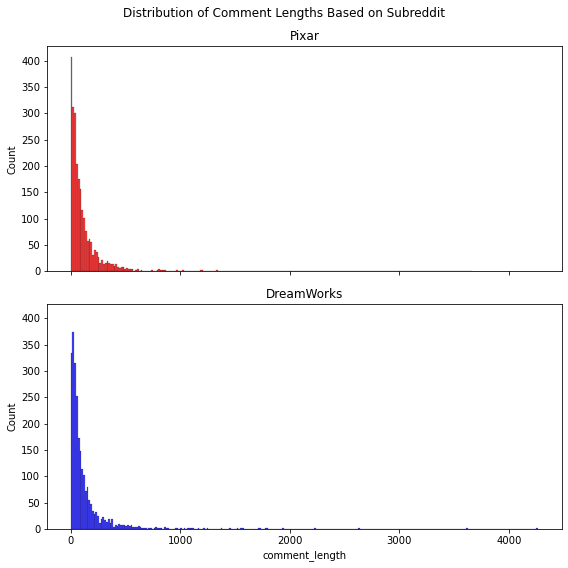

In [189]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True, sharex=True, sharey=True)

sns.histplot(data=df[df['subreddit_name'] == 'Pixar'], x='comment_length', color='red', ax=axes[0]).set(title='Pixar')
sns.histplot(data=df[df['subreddit_name'] == 'DreamWorks'], x='comment_length', color='blue', ax=axes[1]).set(title='DreamWorks');

# Add a Super Title
fig.suptitle('Distribution of Comment Lengths Based on Subreddit', ha='center')

# Saving Figure
fig.get_figure().savefig('../figures/Comment Length Distribution Bases on Subreddit.jpg', bbox_inches='tight')

Based on the histograms above, we can see that the distribution of comment lengths are quite similar between both subreddits. One thing to note is that the majority of short `DreamWorks` comment slightly out number the short `Pixar` comments. This means that the `DreamWorks` subreddit has a bit more shorter comments than `Pixar`.

Now that we looked at the comment lengths of each subreddit, it's time to look at the different words used in each subreddit. Each subreddit could have a set of words that are used more than the other. To do this we will need to `CountVectorize` our comments.

**NOTE:** Since we are still doing EDA, I will split up the messages when we start building the models.

In [190]:
X_eda = df['body']

cvec_eda = CountVectorizer(stop_words='english')
cvec_eda.fit(X_eda)
eda_data = cvec_eda.transform(X_eda)
eda_df = pd.DataFrame(eda_data.todense(), columns=cvec_eda.get_feature_names())

eda_df_master = pd.concat([eda_df, df['subreddit_name']], axis=1)

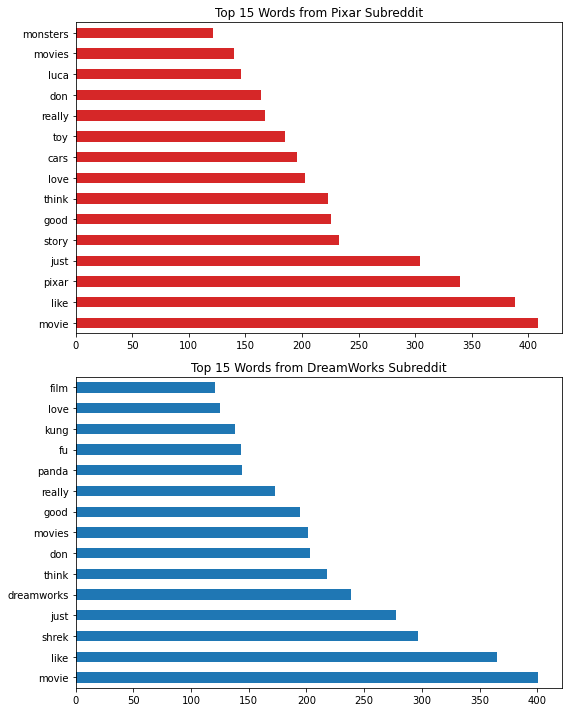

In [284]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10), tight_layout=True)

(eda_df_master[eda_df_master['subreddit_name'] == 'Pixar']
.drop(columns=['subreddit_name'])
.sum()
.sort_values(ascending=False)
.head(15)
.plot(kind='barh', title='Top 15 Words from Pixar Subreddit', color='tab:red', ax=axes[0]));

(eda_df_master[eda_df_master['subreddit_name'] == 'DreamWorks']
.drop(columns=['subreddit_name'])
.sum()
.sort_values(ascending=False)
.head(15)
.plot(kind='barh', title='Top 15 Words from DreamWorks Subreddit', color='tab:blue', ax=axes[1]));

# Saving Figure
fig.get_figure().savefig('../figures/Frequent Words Bases on Subreddit.jpg', bbox_inches='tight')

Above is a list of the top 15 words used in each subreddit, excluding the stop words. As we can see both subreddits us the words `movie` and `like` the most. After that the subreddits start to differ a bit in the words they use the most.

---

## Processing & Modeling

Now we will model our data to try and predict where a comment belongs to the `Pixar` subreddit or the `DreamWorks` subreddit. We will split out data into train and test groups, `CountVectorize` our comments, and then apply them to out models.

In [219]:
# Null Model
df['subreddit_name'].value_counts(normalize=True)

DreamWorks    0.504916
Pixar         0.495084
Name: subreddit_name, dtype: float64

In [265]:
# Train-Test-Split
X = df['body']
y = df['subreddit_name']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, stratify=y)


# Model 1
pipe_1 = Pipeline([
    ('cv', CountVectorizer(min_df=2)),
    ('mnb', MultinomialNB())
])

pipe_1.fit(X_train, y_train)
print(' Model 1 MNB '.center(40, '-'))
print(f'Train Score: \t{pipe_1.score(X_train, y_train):.4f}')
print(f'Test Score: \t{pipe_1.score(X_test, y_test):.4f}')
print('\n')

# Model 2
pipe_2 = Pipeline([
    ('cv', CountVectorizer(min_df=2)),
    ('logr', LogisticRegressionCV(solver='liblinear'))
])

pipe_2.fit(X_train, y_train)
print(' Model 2 Logr '.center(40, '-'))
print(f'Train Score: \t{pipe_2.score(X_train, y_train):.4f}')
print(f'Test Score: \t{pipe_2.score(X_test, y_test):.4f}')
print('\n')

# Model 3
pipe_3 = Pipeline([
    ('cv', CountVectorizer(min_df=2)),
    ('rf', RandomForestClassifier())
])

pipe_3.fit(X_train, y_train)
print(' Model 3 RandomForest '.center(40, '-'))
print(f'Train Score: \t{pipe_3.score(X_train, y_train):.4f}')
print(f'Test Score: \t{pipe_3.score(X_test, y_test):.4f}')
print('\n')


# Model 4
pipe_4 = Pipeline([
    ('cv', CountVectorizer(min_df=2)),
    ('knn', KNeighborsClassifier())
])

pipe_4.fit(X_train, y_train)
print(' Model 4 KNN '.center(40, '-'))
print(f'Train Score: \t{pipe_4.score(X_train, y_train):.4f}')
print(f'Test Score: \t{pipe_4.score(X_test, y_test):.4f}')
print('\n')


# Model 5
pipe_5 = Pipeline([
    ('cv', CountVectorizer(min_df=2)),
    ('rf', RandomForestClassifier())
])

params = {
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 1, 2, 3, 4, 5],
    'rf__max_features': ['sqrt', 0.5]
}

grid = GridSearchCV(pipe_5, param_grid=params, cv=5, n_jobs=-1)

grid.fit(X_train, y_train)
print(' Model 5 RandomForest Grid '.center(40, '-'))
print(f'Parameter: \t{grid.best_params_}')
print(f'Train Score: \t{grid.score(X_train, y_train):.4f}')
print(f'Test Score: \t{grid.score(X_test, y_test):.4f}')
print('\n')

------------- Model 1 MNB --------------
Train Score: 	0.8686
Test Score: 	0.7682


------------- Model 2 Logr -------------
Train Score: 	0.9088
Test Score: 	0.7592


--------- Model 3 RandomForest ---------
Train Score: 	0.9776
Test Score: 	0.7453


------------- Model 4 KNN --------------
Train Score: 	0.7667
Test Score: 	0.5913


------ Model 5 RandomForest Grid -------
Parameter: 	{'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__n_estimators': 100}
Train Score: 	0.9776
Test Score: 	0.7445




---

## Evaluation and Conceptual Understanding

All of the models I created were overfitting, that being said Model 1 did the best overall. Ideally for this model we want to make sure we have a high `accuracy` for it. We also want to maximize our model's `precision` over the other metrics. This way, we may accidentally assign a comment of not being in a subreddit when it is (i.e. say that it does not belong to `Pixar` when it actually does). But this way we will not assign a comment to the wrong subreddit (i.e say that a `DreamWorks` comment is a `Pixar` comment).

We can check our model's `precisions` but getting the `False Positives (FP)`, `True Positives (TP)`, `True Negatives (TN)`, and `False Negatives (FN)` from our best model.

Precision: 	0.7520




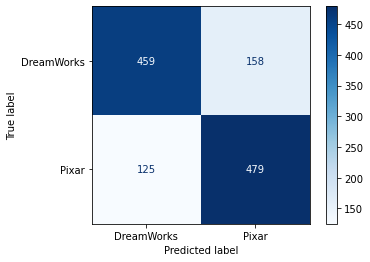

In [283]:
# Get predictions from best model
y_hat = pipe_1.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()

c_matrix = plot_confusion_matrix(pipe_1, X_test, y_test, cmap='Blues')

# Calculate Precision
print(f'Precision: \t{(tp / (tp + fp)):.4f}')
print('\n')
c_matrix.figure_.savefig('../figures/Confusion Matrix.jpg')

Our precision isn't great so we will want to work on tweaking the model in order to get that value as close to `1.000` as possible.

---

## Conclusion and Recommendations
For our problem statement, I would deploy my `Model 1: MultinomialNB()`. With this, we can scrape a bunch of posts from other websites, such as Facebook and Twitter to predict which users might be Pixar fans. We can then run these posts through the predict method for my model.
``` python
pipe_1 = Pipeline([
    ('cv', CountVectorizer(min_df=2)),
    ('mnb', MultinomialNB())
])

pipe_1.fit(X_train, y_train)
pipe_1.predict([YOUR_COMMENT])
```

By passing a list of user comments in the `YOUR_COMMENT` section shown above, it can give `DreamWorks` a prediction on whether or not that person could be a `Pixar` fan; and if so send them DreamWorks advertisements.

Going forward, I would like to use more grid searches to dry and improve my model's `score` as well as increase my `precision score`.

---